# LLM-Guided Quadruped Robot Navigation

This notebook demonstrates how to use a large language model (Gemini) to guide a quadruped robot (Unitree Go1) through a partially known maze environment. The LLM acts as a path planner that suggests waypoints based on the robot's feedback from failed navigation attempts.

## Overview
- The environment is a 5x5 grid maze with some untraversable cells
- The robot starts at (0,0) and needs to reach (4,4)
- The LLM receives feedback from failed attempts to refine its path planning
- The simulation uses MuJoCo physics engine with JAX acceleration

## Installation and Setup
First, let's install the required packages:

In [1]:
%%capture
!pip install mujoco mujoco_mjx brax playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf

In [2]:
%pip install -q -U 'google-generativeai>=0.8.3'

In [1]:
import jax
import numpy as np
import mediapy
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

os.environ["MUJOCO_GL"] = "egl"

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

## Clone the Repository
Clone the repository containing the simulation environment and navigation code:

In [2]:
!git clone https://github.com/shaoanlu/llm_mjx_go1_playground.git

fatal: destination path 'llm_mjx_go1_playground' already exists and is not an empty directory.


In [3]:
%cd llm_mjx_go1_playground

/content/llm_mjx_go1_playground


## Simulation Environment Setup

### Generate Random Maze
We generate a random maze environment with walls and visualize it:
- White cells are traversable
- Black cells are walls/obstacles
- Green dot marks the start position
- Red dot marks the goal position

In [4]:
from src.environment.generate_maze_scene_xml import generate_maze_xml

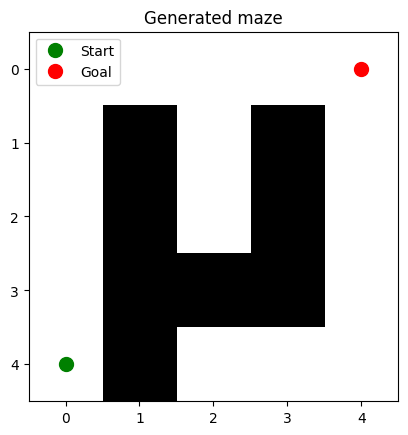

In [5]:
grid, random_maze_xml = generate_maze_xml()

# flips to have origin at bottom-left and goal top-right
im = (np.stack((grid.T[::-1, :],) * 3, axis=-1) * 255).astype(np.uint8)
plt.title("Generated maze")
plt.imshow(im)
plt.plot(0.0, 4.0, "go", markersize=10, label="Start")
plt.plot(4, 0, "ro", markersize=10, label="Goal")
plt.legend(loc="upper left")
plt.show()

!rm -rf scene_mjx_maze_flat_terrain.xml
f = open("scene_mjx_maze_flat_terrain.xml", "a")
f.write(random_maze_xml)
f.close()

### ========== !!!!! BEWARE !!!!! ==========
The following `mv` command overwrites the xml file installed in the mujoco_playground. The modified xml has wall objects added into the scene.

In [6]:
!mv scene_mjx_maze_flat_terrain.xml /usr/local/lib/python3.11/dist-packages/mujoco_playground/_src/locomotion/go1/xmls/scene_mjx_feetonly_flat_terrain.xml

### ========== !!!!! BEWARE !!!!! ==========

### Initialize Simulation
Set up the MuJoCo simulation environment:
- Instantiate the `Go1Env` (which load the maze scene XML)
- Create a traversability map based the random generated maze
- Configure mujoco camera parameters and rendering options

In [7]:
# import mujoco after setting MUJOCO_GL to prevent errors in video rendering
import mujoco
from mujoco_playground._src import mjx_env
from typing import List

from src.environment.env_wrapper import Go1Env
from src.environment.traversability_map import TraversabilityMap, TraversabilityMapConfig
from src.control.controller_factory import ControllerFactory
from src.control.position_controller import PositionController, PositionCommand
from src.control.algorithms.mlp import MLPPolicy, MLPPolicyParams
from src.mission_executer import EpisodeResult, MissionConfig, MissionExecuter
from src.control.position_controller import (
    create_position_controller,
    PositionControllerParams,
    SequentialControllerParams,
    PolarCoordinateControllerParams,
)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [8]:
# instantiate mujoco Env
env_name = "Go1JoystickFlatTerrain"
rng = jax.random.PRNGKey(0)
env = Go1Env(env_name=env_name)

# create traversability map
trav_map_config = TraversabilityMapConfig()
trav_map = TraversabilityMap(trav_map_config)
trav_map.load_from_grid(grid)  # or trav_map.load_grid("assets/floor1.jpg")

array([[1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1],
       [1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1]], dtype=int32)

In [9]:
def modify_scn_fn(scene):
    """Modify the rendering scene to change lighting."""
    light_id = 0  # Adjust this if you have multiple lights
    scene.lights[light_id].ambient = [0.0, 0.0, 0.0]
    scene.lights[light_id].diffuse = [0.1, 0.1, 0.1]  # Change color
    scene.lights[light_id].specular = [0.0, 0.0, 0.0]

    light_id = 1  # Adjust this if you have multiple lights
    scene.lights[light_id].ambient = [0.0, 0.0, 0.0]
    scene.lights[light_id].exponent = 50.0  # Strong falloff at edges
    scene.lights[light_id].cutoff = 65.0  # Spotlight effect
    scene.lights[light_id].diffuse = [1.0, 1.0, 1.0]  # Change color
    scene.lights[light_id].specular = [0.0, 0.0, 0.0]


# Set up the camera
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)

# Object is centered at (0,0,1.5) with size 15m x 15m x 3m
camera.lookat[:] = np.array([2.0, 1.5, 1.5])  # Center of object

# Calculate distance using a safe margin
object_size = 6  # Maximum size in X or Y
fov = 45  # Default MuJoCo camera FOV
safe_margin = 1  # Factor to ensure entire object is in view

# Compute required distance using field of view
camera.distance = (object_size / 2) / np.tan(np.radians(fov / 2)) * safe_margin

# Look directly down
camera.azimuth = 90  # No horizontal rotation
camera.elevation = -70  # Directly downward

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

###  Define Helper Functions

In [10]:
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]


def sample_pert(rng, env, state):
    """
    Random purterbation to the robot
    """
    rng, key1, key2 = jax.random.split(rng, 3)
    pert_mag = jax.random.uniform(key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1])
    duration_seconds = jax.random.uniform(key2, minval=kick_duration_range[0], maxval=kick_duration_range[1])
    duration_steps = jax.numpy.round(duration_seconds / env.dt).astype(jax.numpy.int32)
    state.info["pert_mag"] = pert_mag
    state.info["pert_duration"] = duration_steps
    state.info["pert_duration_seconds"] = duration_seconds
    return rng


def update_position_history(position_history, current_position):
    # Only update position_history is the robot enters a new cell (by comparing position in integer)
    if len(position_history) == 0:
        position_history.append(current_position.astype(np.int32))
        return position_history
    if np.array_equal(position_history[-1].astype(np.int32), current_position.astype(np.int32)):
        return position_history
    else:
        position_history.append(current_position.astype(np.int32))
    return position_history


def run_one_episode(
    env: Go1Env,
    command_generator: PositionController,
    # instead of using base class Controller, we use subclass MLPPolicy as this method is very customized
    command_follower: MLPPolicy,
    traversability_map: TraversabilityMap,
    waypoints: List[np.ndarray],
    max_sim_steps: int,
    rng: jax.Array,
) -> EpisodeResult:
    rollout: List[mjx_env.State] = []
    position_history: List[np.ndarray] = []
    waypoint_idx: int = 0

    _, rng = jax.random.split(rng)
    state = env.reset(rng)

    # start closed-loop sim
    for i in tqdm(range(max_sim_steps)):
        _, rng = jax.random.split(rng)  # this will randomize perturbation
        rng = sample_pert(rng, env, state)

        # calculate control command
        cell_center_offset = 0.5
        target_position = waypoints[waypoint_idx] + cell_center_offset
        pos_command: PositionCommand = command_generator.compute_command(state, target_position)
        state.info["command"] = pos_command.command

        ctrl = command_follower.control(state.obs["state"])  # controller step
        state = env.step(state, ctrl)  # simulator step

        # record
        rollout.append(state)
        position_history = update_position_history(position_history, pos_command.info.pos[:2])

        # check failure
        if not traversability_map.is_valid_position(pos_command.info.pos[:2]):
            return EpisodeResult(status="Stop", position_history=position_history, rollout=rollout)

        # check arrival at current waypoint
        if pos_command.info.is_arrived:
            waypoint_idx = min(waypoint_idx + 1, len(waypoints))  # proceed to next waypoint

            # Check if the arrived at the last waypoint
            if waypoint_idx == len(waypoints):
                return EpisodeResult(status="Success", position_history=position_history, rollout=rollout)

    return EpisodeResult(status="Timeout", position_history=position_history, rollout=rollout)

## Demo: Nagivating a go1 quadruped through a maze with Gemini-thinking Model
**The main navigation loop:**
1. Get waypoints from LLM planner
2. Execute waypoints using controllers
3. Provide feedback to LLM if attempt fails
4. Repeat until goal is reached or max attempts exceeded

The following picture illustrates the flowchart of the navigation task.
![](https://github.com/shaoanlu/llm_mjx_go1_playground/raw/main/assets/llm_go1_navigation.png)


### LLM Path Planner
A free tier Google API key is required to instantiate the `LLMNavigator` class. You can obtain one from [AU Studio](https://aistudio.google.com/app/apikey) with detailed instructions in [this docs](https://ai.google.dev/gemini-api/docs/api-key).

We use the LLM as the path planner:
- Takes the current state and failed attempts as input
- Outputs a sequence of waypoints for the robot to follow
- Adapts the plan based on feedback from failed attempts

In [23]:
from google import genai
from google.colab import userdata
from src.planning.llm_nagivator import GeminiThinkingNavigator


client = genai.Client(api_key=userdata.get("GOOGLE_API_KEY"), http_options={"api_version": "v1alpha"})
llm_navigator = GeminiThinkingNavigator(client, model_name="gemini-2.0-flash-thinking-exp")

### Robot Controller
We use two levels of control:
1. High-level position controller that follows waypoints
2. Low-level MLP policy that controls individual joint movements

In [12]:
# Instantiate controller based on env_name
factory = ControllerFactory()
controller_config = {"algorithm_type": "mlp", "npy_path": f"src/control/nn_params/{env_name}"}
mlp_params = MLPPolicyParams.from_dict(controller_config)
command_follower = factory.build(params=mlp_params)

pc_config = PositionControllerParams(
    # PolarCoordinateControllerParams() is faster but can deviate from the straight path
    primary_controller=SequentialControllerParams(),
    fallback_controller=SequentialControllerParams(),
)
command_generator = create_position_controller(controller_factory=factory, config=pc_config)

# Instantiate the ochestrator for mission execution
instruction = open("examples/prompt.txt", "r").read()
mission_config = MissionConfig()
mission_config.max_attempts = 20
mission_config.max_sim_steps = 1000
mission_executer = MissionExecuter(config=mission_config, instruction_prompt=instruction)
mission_config

MissionConfig(goal=(4, 4), max_sim_steps=1000, retry_delay_sec=5, max_attempts=20)

### Create a partially applied function with fixed arguments for closed-loop simulation

In [13]:
from functools import partial

run_one_episode_func = partial(
    run_one_episode,
    env=env,
    command_generator=command_generator,
    command_follower=command_follower,
    traversability_map=trav_map,
)

## Start Navigation

I takes some time for the first simulation step. During simulation, the intermediate reuslt of attemps will be printed out, including the prompt, the waypoints suggested by LLM, and the result.

In [24]:
result = mission_executer.execute_mission(planner=llm_navigator, execute_single_attempt=run_one_episode_func, rng=rng)

 20%|██        | 204/1000 [00:03<00:15, 51.62it/s]


[Trial 1]
prompt='You are a path planner for a quadruped robot navigating in a partially known 5x5 grid environment. Your task is to guide the robot from the start position (0,0) to the goal position (4,4).\n\nEnvironment specifications:\n- Grid size: 5x5\n- Start position: (0,0)\n- Goal position: (4,4)\n- Some cells are not traversable, but their status is only revealed when the robot attempts to traverse them\n\nPath planning constraints:\n1. Maximum 10 waypoints allowed per path\n2. Consecutive waypoints moving in the same direction must be simplified\n   Example: [(0,0), (1,0), (2,0), (2,1)] should be simplified to [(0,0), (2,0), (2,1)]\n\nExpected output format:\nProvide only a list of coordinates in the format:\n[(x0,y0), (x1,y1), ..., (xn,yn)]\n\nPossible execution outcomes:\n1. Success: Robot reaches the goal\n2. Failed (Obstacle): "Failed: stop at (X,Y), traversed cells: [(x0,y0), (x1,y1), ...]"\n   - Episode terminates when hitting an untraversable cell\n   - Remaining waypoi

 12%|█▏        | 119/1000 [00:01<00:13, 67.26it/s]


[Trial 2]
prompt='Failed: Stop at (1, 1), traversed cells: [(0, 0), (0, 1), (1, 1)]'
waypoints=[array([0, 0]), array([4, 0]), array([4, 4])]
result.status='Stop'(1, 0) 	result.position_history=[array([0, 0], dtype=int32), array([1, 0], dtype=int32)]



 26%|██▌       | 257/1000 [00:03<00:10, 71.95it/s]


[Trial 3]
prompt='Failed: Stop at (1, 0), traversed cells: [(0, 0), (1, 0)]'
waypoints=[array([0, 0]), array([0, 2]), array([4, 2]), array([4, 4])]
result.status='Stop'(1, 2) 	result.position_history=[array([0, 0], dtype=int32), array([0, 1], dtype=int32), array([0, 2], dtype=int32), array([1, 2], dtype=int32)]



 13%|█▎        | 128/1000 [00:01<00:13, 65.26it/s]


[Trial 4]
prompt='Failed: Stop at (1, 2), traversed cells: [(0, 0), (0, 1), (0, 2), (1, 2)]'
waypoints=[array([0, 0]), array([2, 0]), array([2, 4]), array([4, 4])]
result.status='Stop'(1, 0) 	result.position_history=[array([0, 0], dtype=int32), array([1, 0], dtype=int32)]



 32%|███▏      | 324/1000 [00:07<00:15, 44.21it/s]


[Trial 5]
prompt='Failed: Stop at (1, 0), traversed cells: [(0, 0), (1, 0)]'
waypoints=[array([0, 0]), array([0, 3]), array([4, 3]), array([4, 4])]
result.status='Stop'(1, 3) 	result.position_history=[array([0, 0], dtype=int32), array([0, 1], dtype=int32), array([0, 2], dtype=int32), array([0, 3], dtype=int32), array([1, 3], dtype=int32)]



 52%|█████▏    | 523/1000 [00:11<00:10, 47.33it/s]

[Trial 6]
prompt='Failed: Stop at (1, 3), traversed cells: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3)]'
waypoints=[array([0, 0]), array([0, 4]), array([4, 4])]
result.status='Success'(4, 4) 	result.position_history=[array([0, 0], dtype=int32), array([0, 1], dtype=int32), array([0, 2], dtype=int32), array([0, 3], dtype=int32), array([0, 4], dtype=int32), array([1, 4], dtype=int32), array([2, 4], dtype=int32), array([3, 4], dtype=int32), array([4, 4], dtype=int32)]



## Results Visualization

### Render Navigation Video
Visualize the successful navigation attempt:
- Shows the robot's movement through the maze
- Includes fog of war effect to highlight explored areas
- Demonstrates how the robot avoids discovered obstacles

In [15]:
render_every = 10
fps = 3.0 / env.dt / render_every  # 3x realtime
traj = result.rollouts[::render_every]


frames = env.render(
    traj, camera=camera, scene_option=scene_option, height=480, width=640, modify_scene_fns=[modify_scn_fn] * len(traj)
)

100%|██████████| 135/135 [01:39<00:00,  1.36it/s]


In [ ]:
from src.visualization import apply_fog_of_war

# mediapy.show_video(frames, fps=fps, loop=False)
mediapy.show_video(apply_fog_of_war(frames, alpha=0.7, gamma=1.1), fps=fps, loop=False)

array([[[23, 23, 23],
        [23, 23, 23],
        [23, 23, 23],
        ...,
        [23, 23, 23],
        [23, 23, 23],
        [23, 23, 23]],

       [[23, 23, 23],
        [23, 23, 23],
        [23, 23, 23],
        ...,
        [23, 23, 23],
        [23, 23, 23],
        [23, 23, 23]],

       [[23, 23, 23],
        [23, 23, 23],
        [23, 23, 23],
        ...,
        [23, 23, 23],
        [23, 23, 23],
        [23, 23, 23]],

       ...,

       [[45, 45, 45],
        [46, 46, 46],
        [45, 45, 45],
        ...,
        [23, 23, 23],
        [24, 24, 24],
        [24, 24, 24]],

       [[45, 45, 45],
        [45, 45, 45],
        [44, 44, 44],
        ...,
        [23, 23, 23],
        [24, 24, 24],
        [24, 24, 24]],

       [[45, 45, 45],
        [45, 45, 45],
        [42, 42, 42],
        ...,
        [22, 22, 22],
        [24, 24, 24],
        [24, 24, 24]]], dtype=uint8)
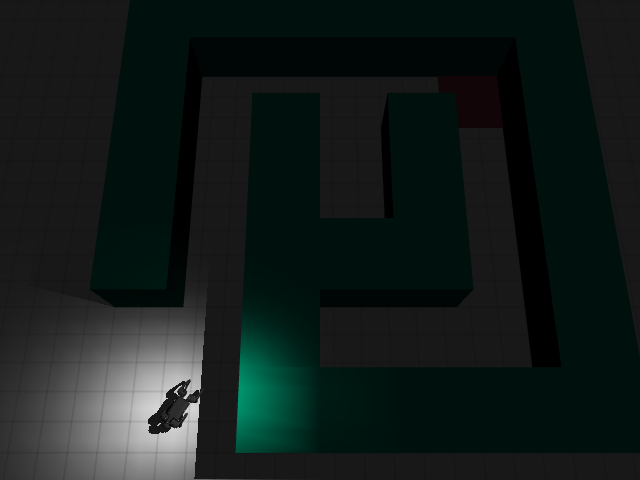

In [19]:
frames[0]

## Extra: Ask LLM to infer the map with uncertainty

In [26]:
def create_ask_for_map_prompt(result):
    x, y = result.position_history[-1].astype(int)
    return (
        f"Success: reached ({x}, {y}), traversed cells: {[tuple(np.round(x_, 1)) for x_ in result.position_history]}"
    )


create_ask_for_map_prompt(result)

'Success: reached (4, 4), traversed cells: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]'

In [29]:
response = llm_navigator.chat.send_message(
    [
        create_ask_for_map_prompt(result)
        + f"Now, based on all of the attemps, reason about the environment from start to goal and draw a 5x5 grid map using '0', '1', and '?', where '0' repreents a wall, '1' a path cell, and '?' a cell you are uncertain."
    ]
)

In [30]:
print(response.text)
# this actually match the explored cell of the robot

```
1 1 1 1 1
0 0 0 0 1
? ? ? ? 1
? ? ? ? 1
? ? ? ? 1
```


And ask LLM to plan more paths to epxlore the entire map

In [31]:
llm_navigator.chat.send_message(["Suggest 5 more paths in order for you to fill the unknow cells"]).text
# these paths are not the most effective ones though (many of them lead to hitting the wall immediately)

'[(0,0), (2,0), (2,1), (2,2), (2,3), (2,4)]\n[(0,0), (3,0), (3,1), (3,2), (3,3), (3,4)]\n[(0,0), (4,0), (4,1), (4,2), (4,3)]\n[(0,0), (0,4), (4,4), (4,0), (3,0), (2,0)]\n[(0,0), (0,4), (4,4), (4,2), (3,2), (2,2)]'